In [36]:
import torch
import torch.nn as nn
from torchvision import models

In [37]:
model = models.mobilenet_v2(pretrained=True)
#model
#this model is more computationally heavy and less well-performing than the MobilenetV3 smalll model

/Users/szaboreka/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Code for mobilenetV2 with LTSM

In [23]:
import torch
import torch.nn as nn
from torchvision import models

class MobileNetV2_LSTM(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, lstm_layers=1, bidirectional=False):
        super(MobileNetV2_LSTM, self).__init__()
        
        #extract features from the mobilenet v2 model - output: 1280
        self.feature_extractor = models.mobilenet_v2(pretrained=True, progress=True).features

        #pooling - because we are using just the features (not containing the last pooling)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        #lstm layer
        self.lstm = nn.LSTM(1280, hidden_dim, lstm_layers, batch_first=True, bidirectional=bidirectional)

        #linear layer to get prediction
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.feature_extractor(c_in)
        print("c_out before pooling shape", c_out.shape)
        #shape: batch_size * timesteps, features, 1, 1
        c_out = self.pool(c_out)
        print("c_out after pooling shape", c_out.shape)
        #lstm layer needs a 3D tensor, with shape (batch, timesteps, feature)
        c_out = c_out.view(batch_size, timesteps, -1)
        print('c_out', c_out.shape)
        
        lstm_out, _ = self.lstm(c_out)
        
        out = self.fc(lstm_out[:, -1, :])
        return out

#Example
model = MobileNetV2_LSTM(num_classes=2)
input_tensor = torch.randn(8, 16, 3, 224, 224)
output = model(input_tensor)
print(output.shape)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)
top1_prob, top1_catid = torch.topk(probabilities, 1)
print(top1_prob, top1_catid)

#it is not that computationally effective as it can crash the kernel when running on CPU

/Users/szaboreka/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


: 

MobileNetV3 small

In [16]:
model = models.mobilenet_v3_small(pretrained=True)
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [17]:
#examining just the features of the model
model = models.mobilenet_v3_small(pretrained=True).features
model

/Users/szaboreka/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/szaboreka/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (1): InvertedResidual(
    (block): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): SqueezeExcitation(
        (avgpool): AdaptiveAvgPool2d(output_size=1)
        (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
        (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        (activation): ReLU()
        (scale_activation): Hardsigmoid()
      )
      (2): Conv2dNormActivation(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, mo

Preprocessing:

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    #transforms.CenterCrop(224), #exlude center crop (the smoke can be anywhere)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Code for the MobilenetV3 small + LSTM/GRU model - trying out and understanding dimensions

In [6]:
import torch
import torch.nn as nn
from torchvision import models

class MobileNetV3Small_RNN(nn.Module):
    def __init__(self, num_classes, rnn_type="LSTM"):
        super(MobileNetV3Small_RNN, self).__init__()
        #load the model
        self.mobilenet = models.mobilenet_v3_small(pretrained=True)

        #extract features from final layer - pooling is exluded
        self.feature_extractor = self.mobilenet.features

        #Pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        #get the number of features output by MobileNetV3 - for input for RNN
        self.num_features = self.mobilenet.classifier[0].in_features

        #room for rnn type choice: LSTM or GRU
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(self.num_features, hidden_size=256, num_layers=1, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(self.num_features, hidden_size=256, num_layers=1, batch_first=True)
        else:
            raise ValueError("Invalid RNN type. Choose 'LSTM' or 'GRU'.")

        #final classification layer - to get logits for the two classes
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        #accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. 
        #reshape input for feature extraction - mobilenet can only take images (4 d)
        c_in = x.view(batch_size * timesteps, C, H, W)
        
        #extract features with mobilenet
        features = self.feature_extractor(c_in)
        
        #pooling - using the same one as in the mobilenet architecture
        #lstm layer needs a 3D tensor, with shape (batch, timesteps, feature)
        features = self.pool(features).view(batch_size, timesteps, -1)

        #get rnn output by passing the features to the selected rnn
        rnn_out, _ = self.rnn(features)
        
        #batch, timesteps, output features
        #only select the last of the timesteps as it holds the information of the whole video
        last_output = rnn_out[:, -1, :]
        logits = self.fc(last_output)
        
        return logits


In [48]:
#Experiment: rnn_type can be LSTM and GRU
model = MobileNetV3Small_RNN(num_classes=2, rnn_type="GRU")
# Modelling the merged dataset: batchsize of 8, 36 frames per video, rgb, 224x224 frames (needs preprocessing)
video_tensor = torch.randn(8, 36, 3, 224, 224)  
predictions = model(video_tensor)

print(predictions.size())

probabilities = torch.nn.functional.softmax(predictions)
print(probabilities)
top1_prob, top1_catid = torch.topk(probabilities, 1)
print("Class: ", top1_catid, ":", top1_prob)

#LSTM runs for 7.3s
#GRU runs for 8.4 s

torch.Size([8, 2])
tensor([[0.5143, 0.4857],
        [0.4431, 0.5569],
        [0.4896, 0.5104],
        [0.4948, 0.5052],
        [0.5098, 0.4902],
        [0.4948, 0.5052],
        [0.5107, 0.4893],
        [0.5215, 0.4785]], grad_fn=<SoftmaxBackward0>)
Class:  tensor([[0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0]]) : tensor([[0.5143],
        [0.5569],
        [0.5104],
        [0.5052],
        [0.5098],
        [0.5052],
        [0.5107],
        [0.5215]], grad_fn=<TopkBackward0>)


/var/folders/9v/r3fdnxqn6v740_k7q9q14pym0000gn/T/ipykernel_29050/699404125.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(predictions)


Examining EfficientNetB0 

In [2]:
import torch
import torch.nn as nn
from torchvision import models

class EfficientNetB0_RNN(nn.Module):
    def __init__(self, num_classes, rnn_type="LSTM"):
        super(EfficientNetB0_RNN, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        #feature extraction without last pooling layer
        self.feature_extractor = self.efficientnet.features

        #get number of features output by model
        self.num_features = self.efficientnet.classifier[1].in_features

        #define the rnn layer type
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(self.num_features, hidden_size=256, num_layers=1, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(self.num_features, hidden_size=256, num_layers=1, batch_first=True)
        else:
            raise ValueError("Invalid RNN type. Choose 'LSTM' or 'GRU'.")

        #classification layer to get logits
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        #reshape to fit the cnn input requirements
        c_in = x.view(batch_size * timesteps, C, H, W)
        
        #extract features
        features = self.feature_extractor(c_in)
        
        #pooling and reshaping to get (batch, timesteps, features) for rnn
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).reshape(batch_size, timesteps, -1)

        #rnn layer
        rnn_out, _ = self.rnn(features)

        #only get the last element of timesteps
        last_output = rnn_out[:, -1, :]

        #pass thorugh fully connected layer to get logits
        logits = self.fc(last_output)
        
        return logits

#try model with random example 
model = EfficientNetB0_RNN(num_classes=2, rnn_type="GRU")
video_tensor = torch.randn(8, 16, 3, 224, 224)
predictions = model(video_tensor)

#print out size - should be batch,classes
print(predictions.size())

probabilities = torch.nn.functional.softmax(predictions)
print(probabilities)
top1_prob, top1_catid = torch.topk(probabilities, 1)
print("Class: ", top1_catid, ":", top1_prob)

#for LSTM: 26s
#for GRU: 46.4s


torch.Size([8, 2])


/var/folders/9v/r3fdnxqn6v740_k7q9q14pym0000gn/T/ipykernel_29050/667827384.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.functional.softmax(predictions)


tensor([[0.4682, 0.5318],
        [0.4987, 0.5013],
        [0.4693, 0.5307],
        [0.4363, 0.5637],
        [0.5007, 0.4993],
        [0.5080, 0.4920],
        [0.5153, 0.4847],
        [0.4742, 0.5258]], grad_fn=<SoftmaxBackward0>)
Class:  tensor([[1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1]]) : tensor([[0.5318],
        [0.5013],
        [0.5307],
        [0.5637],
        [0.5007],
        [0.5080],
        [0.5153],
        [0.5258]], grad_fn=<TopkBackward0>)


Conclusion: MobilenetV3 small is significantly more efficient, the LSTM layer seems more efficient, too. I will experiment with MobileNetV3 small with LSTM or GRU layers to find the best model.

Creating code for training:

In [3]:
#Import packages
import os
import clip
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import json
import cv2
from torchvision.transforms import ToTensor
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import torch
import torch.nn as nn
from torchvision import models

In [4]:
# Define device
if torch.cuda.is_available():
    device = torch.device("cuda") # use CUDA device
#elif torch.backends.mps.is_available():
#    device = torch.device("mps") # use MacOS GPU device (e.g., for M2 chips)
else:
    device = torch.device("cpu") # use CPU device
print('Used device: ', device)

Used device:  cpu


In [36]:
model = MobileNetV3Small_RNN(num_classes=2, rnn_type="LSTM")
model = model.to(device)

/Users/szaboreka/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/szaboreka/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
# Load the dataset
class ImageTitleDataset(Dataset):
    def __init__(self, list_video_path, list_labels, transform_image):
        #to handle the parent class
        super().__init__()
        #Initalize image paths and corresponding texts
        self.video_path = list_video_path
        #Initialize labels (0 or 1)
        self.labels = list_labels
        #Transform images based on defined transformation
        self.transform_image = transform_image

    @staticmethod
    #Function to create a square-shaped image from the video (similar to 1 long image)

    def preprocess_video_to_a_set_of_images(video_path):
        #Open the video file
        video = cv2.VideoCapture(video_path)
        #Create list for extracted frames
        frames = []
        #Handle if video can't be opened
        if not video.isOpened():
            print("Error: Could not open video file")
        else:
            while True:
                is_read, frame = video.read()
                if not is_read:
                    break
                frames.append(frame)
            video.release()
        
        if len(frames) != 36:
            print("Num of frames are not 36")
            print("Num of frames for video on ", video_path, "is ", len(frames))
        
        return frames

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #tranform videos into images and preprocess with defined transform function
        video_path = self.video_path[idx]
        frames = self.preprocess_video_to_a_set_of_images(video_path)
        frames = [self.transform_image(Image.fromarray(frame)) for frame in frames]
        frames = torch.stack(frames)

        #get the corresponding class names
        label = self.labels[idx]
        return frames, label

In [38]:
#Define training data
# Load the JSON metadata
with open('data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    train_data = json.load(f)
# Convert the dataset to a Pandas DataFrame
train_data = pd.DataFrame(train_data)
# Prepare the list of video file paths and labels
list_video_path = [os.path.join("data/ijmond_videos/", f"{fn}.mp4") for fn in train_data['file_name']]
#list_labels = dataset['label'].tolist()
list_labels = [int(label) for label in train_data['label']]

In [59]:
# Define input resolution
input_resolution = (256, 256)

# Define the transformation pipeline - from CLIP preprocessor without random crop augmentation
transform = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [60]:
# Create dataset and data loader for training
train_dataset = ImageTitleDataset(list_video_path, list_labels, transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [66]:
# Create dataset and data loader for val
val_dataset = ImageTitleDataset(list_video_path, list_labels, transform)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [67]:
# Create dataset and data loader for test
test_dataset = ImageTitleDataset(list_video_path, list_labels, transform)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [61]:
#inspect the first batch in the DataLoader
def inspect_dataloader(dataloader):
    for batch_idx, (images, labels) in enumerate(dataloader):
        print(f"Batch {batch_idx + 1}")
        print(f"Images shape: {images.shape}")
        # Should be (4, 36, 3, 224, 224) - batch_size, frames, rgb, width, height
        print(f"Labels: {labels}")
        break

inspect_dataloader(train_dataloader)

Batch 1
Images shape: torch.Size([4, 36, 3, 256, 256])
Labels: tensor([1, 1, 1, 0])


In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
loss = nn.CrossEntropyLoss()

In [64]:
num_epochs = 1
best_te_loss = 1e5
best_ep = -1
early_stopping_counter = 0
early_stopping_patience = 4

for epoch in range(num_epochs):
    print(f"running epoch {epoch}, best test loss {best_te_loss} after epoch {best_ep}")
    step = 0
    tr_loss = 0
    model.train()
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        step += 1

        # Extract images and labels from the batch
        images, labels = batch 
        print(images.shape)

        # Move images and texts to the specified device (CPU or GPU)
        images= images.to(device)
        labels = labels.to(device)

        predictions = model(images)
        batch_loss = loss(predictions, labels)
        tr_loss += batch_loss.item()

        # Calculate accuracy
        probabilities = torch.argmax(predictions, dim=1)
        print(probabilities)
        train_accuracy = accuracy_score(labels.cpu().numpy(), probabilities.cpu().numpy())
        print('Train accuracy: ', train_accuracy)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        #scheduler.step()
        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {batch_loss.item():.4f}, Current Learning rate: {optimizer.param_groups[0]['lr']}")
    tr_loss /= step

    print('Validation loop starts')
    model.eval()
    step = 0
    te_loss = 0
    val_losses = []
    val_accs = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        vbar = tqdm(val_dataloader, total=len(val_dataloader))
        i = 0
        for batch in vbar:
            step += 1
            images, labels = batch
            images= images.to(device)
            labels = labels.to(device)
            predictions = model(images)
            val_loss = loss(predictions, labels)
            te_loss += val_loss.item()

            pred_labels = predictions.argmax(dim=1)

            # Append predicted labels and ground truth labels
            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Append loss
            val_losses.append(val_loss.item())
        
            # Update the progress bar with the current epoch and loss
            vbar.set_description(f"Validation: {i}/{len(val_dataloader)}, Validation loss: {val_loss.item():.4f}")
            i+=1

        te_loss /= step
    
     # Convert lists of arrays to numpy arrays
    all_labels_array = np.concatenate(all_labels)
    all_preds_array = np.concatenate(all_preds)

    # Convert to 1D arrays
    all_labels_flat = all_labels_array.flatten()
    all_preds_flat = all_preds_array.flatten()

    # Ensure they are integers
    all_labels_int = all_labels_flat.astype(int)
    all_preds_int = all_preds_flat.astype(int)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels_int, all_preds_int)

    # Print or visualize the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    #get evaluation metrics:

    precision = precision_score(all_labels_int, all_preds_int, average='binary')
    recall = recall_score(all_labels_int, all_preds_int, average='binary')
    f_score= f1_score(all_labels_int, all_preds_int, average='binary')
    acc = accuracy_score(all_labels_int, all_preds_int)

    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1 Score: {f_score:.4f}")

    if te_loss < best_te_loss:
        best_te_loss = te_loss
        best_ep = epoch
        torch.save(model.state_dict(), "../light_cnn_best_model.pt")
        early_stopping_counter = 0 
    else:
        early_stopping_counter += 1

    print(f"epoch {epoch}, tr_loss {tr_loss}, te_loss {te_loss}")

    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping after {epoch + 1} epochs.")
        break
    
print(f"best epoch {best_ep+1}, best te_loss {best_te_loss}")
torch.save(model.state_dict(), "../light_cnn_last_model.pt")

  0%|          | 0/7 [00:00<?, ?it/s]

torch.Size([4, 36, 3, 256, 256])
tensor([1, 0, 0, 1])
Train accuracy:  0.75


Epoch 0/1, Loss: 0.6662:  14%|█▍        | 1/7 [00:15<01:35, 15.92s/it]

torch.Size([4, 36, 3, 256, 256])
tensor([0, 0, 0, 0])
Train accuracy:  0.25


Epoch 0/1, Loss: 0.8104:  29%|██▊       | 2/7 [00:29<01:12, 14.54s/it]

torch.Size([4, 36, 3, 256, 256])
tensor([0, 0, 0, 0])
Train accuracy:  0.75


Epoch 0/1, Loss: 0.8104:  29%|██▊       | 2/7 [00:43<01:49, 21.87s/it]


KeyboardInterrupt: 

In [70]:
print("start testing")
model.eval()
test_losses = []
test_accs = []
test_preds = []
test_labels = []
with torch.no_grad():
    tbar = tqdm(test_dataloader, total=len(test_dataloader))
    i = 0
    for batch in tbar:
        images, labels = batch
        images= images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        test_loss = loss(predictions, labels)

        pred_labels = predictions.argmax(dim=1)

        # Append predicted labels and ground truth labels
        test_preds.extend(pred_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

        # Append loss
        test_losses.append(test_loss.item())
    
    # Update the progress bar with the current epoch and loss
    tbar.set_description(f"Testing: {i}/{len(test_dataloader)}, Test loss: {test_loss.item():.4f}")
    i+=1

# Convert lists of arrays to numpy arrays
all_labels_array = np.concatenate(test_labels)
all_preds_array = np.concatenate(test_preds)

# Convert to 1D arrays
all_labels_flat = all_labels_array.flatten()
all_preds_flat = all_preds_array.flatten()

# Ensure they are integers
all_labels_int = all_labels_flat.astype(int)
all_preds_int = all_preds_flat.astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels_int, all_preds_int)

# Print or visualize the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

#get evaluation metrics:

precision = precision_score(all_labels_int, all_preds_int, average='binary')
recall = recall_score(all_labels_int, all_preds_int, average='binary')
f_score= f1_score(all_labels_int, all_preds_int, average='binary')
acc = accuracy_score(all_labels_int, all_preds_int)

# Print or log the metrics
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f_score:.4f}")

print("CLIP model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")

# Classification report
target_names = ['class 0', 'class 1']
print(classification_report(all_labels_int, all_preds_int , target_names=target_names))

start testing


 43%|████▎     | 3/7 [00:12<00:17,  4.32s/it]


KeyboardInterrupt: 

/Users/szaboreka/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/szaboreka/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Used device:  cpu
Datasets created
Dataloaders created
running epoch 0, best test loss 100000.0 after epoch -1


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([8, 36, 3, 256, 256])


Epoch 0/1, Loss: 0.7322, Current Learning rate: 0.1:  25%|██▌       | 1/4 [00:32<01:36, 32.18s/it]

torch.Size([8, 36, 3, 256, 256])


Epoch 0/1, Loss: 3.2667, Current Learning rate: 0.1:  50%|█████     | 2/4 [01:01<01:01, 30.73s/it]

torch.Size([8, 36, 3, 256, 256])


Epoch 0/1, Loss: 7.1069, Current Learning rate: 0.1:  75%|███████▌  | 3/4 [01:29<00:29, 29.43s/it]

torch.Size([2, 36, 3, 256, 256])


Epoch 0/1, Loss: 2.6335, Current Learning rate: 0.1: 100%|██████████| 4/4 [01:35<00:00, 23.94s/it]


Train accuracy:  0.4230769230769231
Validation loop starts


Validation: 0/1, Validation loss: 6.3810: 100%|██████████| 1/1 [00:22<00:00, 22.09s/it]
/Users/szaboreka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation accuracy:  0.5
Confusion Matrix:
[[13  0]
 [13  0]]
Validation Accuracy: 0.5000
Validation Precision: 0.0000
Validation Recall: 0.0000
Validation F1 Score: 0.0000
epoch 0, tr_loss 3.4348270893096924, te_loss 6.380963325500488
best epoch 1, best te_loss 6.380963325500488
start testing


Testing: 0/1, Test loss: 6.3810: 100%|██████████| 1/1 [00:21<00:00, 21.68s/it]
/Users/szaboreka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szaboreka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/szaboreka/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

Start time:  2024-05-24 00:11:13.731959
Ending time:  2024-05-24 00:11:35.415512
Overall time:  0:00:21.683553
Confusion Matrix:
[[13  0]
 [13  0]]
Test Accuracy: 0.5000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1 Score: 0.0000
CLIP model parameters: 3,397,386
              precision    recall  f1-score   support

     class 0       0.50      1.00      0.67        13
     class 1       0.00      0.00      0.00        13

    accuracy                           0.50        26
   macro avg       0.25      0.50      0.33        26
weighted avg       0.25      0.50      0.33        26



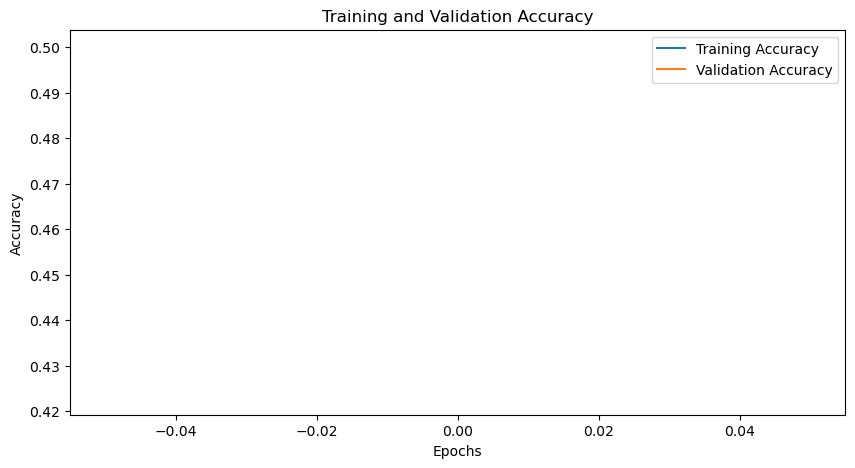

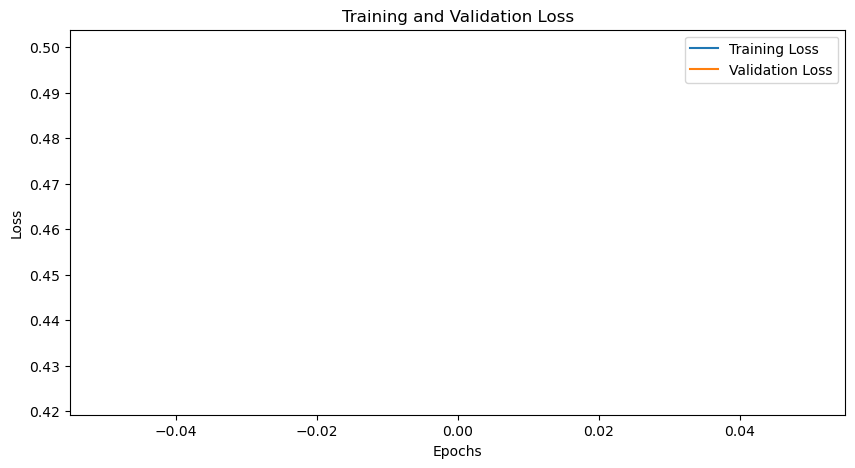

In [75]:
#Import packages
import os
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import json
import cv2
from torchvision.transforms import ToTensor
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from datetime import datetime

# Define device
if torch.cuda.is_available():
    device = torch.device("cuda") # use CUDA device
#elif torch.backends.mps.is_available():
#    device = torch.device("mps") # use MacOS GPU device (e.g., for M2 chips)
else:
    device = torch.device("cpu") # use CPU device
print('Used device: ', device)

import torch
import torch.nn as nn
from torchvision import models

class MobileNetV3Small_RNN(nn.Module):
    def __init__(self, num_classes, rnn_type="LSTM"):
        super(MobileNetV3Small_RNN, self).__init__()
        #load the model
        self.mobilenet = models.mobilenet_v3_small(pretrained=True)

        #extract features from final layer - pooling is exluded
        self.feature_extractor = self.mobilenet.features

        #Pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        #get the number of features output by MobileNetV3 - for input for RNN
        self.num_features = self.mobilenet.classifier[0].in_features

        #room for rnn type choice: LSTM or GRU
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(self.num_features, hidden_size=256, num_layers=1, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(self.num_features, hidden_size=256, num_layers=1, batch_first=True)
        else:
            raise ValueError("Invalid RNN type. Choose 'LSTM' or 'GRU'.")

        #final classification layer - to get logits for the two classes
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        #accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. 
        #reshape input for feature extraction - mobilenet can only take images (4 d)
        c_in = x.view(batch_size * timesteps, C, H, W)
        
        #extract features with mobilenet
        features = self.feature_extractor(c_in)
        
        #pooling - using the same one as in the mobilenet architecture
        #lstm layer needs a 3D tensor, with shape (batch, timesteps, feature)
        features = self.pool(features).view(batch_size, timesteps, -1)

        #get rnn output by passing the features to the selected rnn
        rnn_out, _ = self.rnn(features)
        
        #batch, timesteps, output features
        #only select the last of the timesteps as it holds the information of the whole video
        last_output = rnn_out[:, -1, :]
        logits = self.fc(last_output)
        
        return logits


model = MobileNetV3Small_RNN(num_classes=2, rnn_type="LSTM")
model = model.to(device)

# Load the dataset
class ImageTitleDataset(Dataset):
    def __init__(self, list_video_path, list_labels, transform_image):
        #to handle the parent class
        super().__init__()
        #Initalize image paths and corresponding texts
        self.video_path = list_video_path
        #Initialize labels (0 or 1)
        self.labels = list_labels
        #Transform images based on defined transformation
        self.transform_image = transform_image

    @staticmethod
    #Function to create a square-shaped image from the video (similar to 1 long image)

    def preprocess_video_to_a_set_of_images(video_path):
        #Open the video file
        video = cv2.VideoCapture(video_path)
        #Create list for extracted frames
        frames = []
        #Handle if video can't be opened
        if not video.isOpened():
            print("Error: Could not open video file")
        else:
            while True:
                is_read, frame = video.read()
                if not is_read:
                    break
                frames.append(frame)
            video.release()
        
        if len(frames) != 36:
            print("Num of frames are not 36")
            print("Num of frames for video on ", video_path, "is ", len(frames))
        
        return frames

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #tranform videos into images and preprocess with defined transform function
        video_path = self.video_path[idx]
        frames = self.preprocess_video_to_a_set_of_images(video_path)
        frames = [self.transform_image(Image.fromarray(frame)) for frame in frames]
        frames = torch.stack(frames)

        #get the corresponding class names
        label = self.labels[idx]
        return frames, label
    

#Define training, validation and test data
# Load the JSON metadata
with open('data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    train_data = json.load(f)
with open('data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    val_data = json.load(f)
with open('data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    test_data = json.load(f)

# Convert the datasets to a Pandas DataFrame
train_data = pd.DataFrame(train_data)
val_data = pd.DataFrame(val_data)
test_data = pd.DataFrame(test_data)

# Prepare the list of video file paths and labels
train_list_video_path = [os.path.join("data/ijmond_videos/", f"{fn}.mp4") for fn in train_data['file_name']]
train_list_labels = [int(label) for label in train_data['label']]
val_list_video_path = [os.path.join("data/ijmond_videos/", f"{fn}.mp4") for fn in val_data['file_name']]
val_list_labels = [int(label) for label in val_data['label']]
test_list_video_path = [os.path.join("data/ijmond_videos/", f"{fn}.mp4") for fn in test_data['file_name']]
test_list_labels = [int(label) for label in test_data['label']]

# Define input resolution
input_resolution = (256, 256)

# Define the transformation pipeline - from CLIP preprocessor without random crop augmentation
train_transform = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and data loader for training, validation and testing
train_dataset = ImageTitleDataset(train_list_video_path, train_list_labels, train_transform)
val_dataset = ImageTitleDataset(val_list_video_path, val_list_labels, val_test_transform)
test_dataset = ImageTitleDataset(test_list_video_path, test_list_labels, val_test_transform)

print('Datasets created')

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print('Dataloaders created')

num_epochs = 30

optimizer = torch.optim.Adam(model.parameters(), lr=0.1,betas=(0.9,0.98),eps=1e-6,weight_decay=1e-6)
loss = nn.CrossEntropyLoss()
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dataloader)*num_epochs)

num_epochs = 1
best_te_loss = 1e5
best_ep = -1
early_stopping_counter = 0
early_stopping_patience = 4
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"running epoch {epoch}, best test loss {best_te_loss} after epoch {best_ep}")
    step = 0
    tr_loss = 0
    model.train()
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    epoch_train_correct = 0
    epoch_train_total = 0
    for batch in pbar:
        step += 1

        # Extract images and labels from the batch
        images, labels = batch 
        print(images.shape)

        # Move images and texts to the specified device (CPU or GPU)
        images= images.to(device)
        labels = labels.to(device)

        predictions = model(images)
        batch_loss = loss(predictions, labels)
        tr_loss += batch_loss.item()

        # Calculate accuracy
        probabilities = torch.argmax(predictions, dim=1)

        correct = (probabilities == labels).sum().item()
        total = labels.size(0)
        epoch_train_correct += correct
        epoch_train_total += total

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        #scheduler.step()
        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {batch_loss.item():.4f}, Current Learning rate: {optimizer.param_groups[0]['lr']}")
    tr_loss /= step
    train_accuracy = epoch_train_correct / epoch_train_total
    print('Train accuracy: ', train_accuracy)
    train_accuracies.append(train_accuracy)
    train_losses.append(tr_loss)

    print('Validation loop starts')
    model.eval()
    step = 0
    te_loss = 0
    all_preds = []
    all_labels = []
    epoch_val_correct = 0
    epoch_val_total = 0
    with torch.no_grad():
        vbar = tqdm(val_dataloader, total=len(val_dataloader))
        i = 0
        for batch in vbar:
            step += 1
            images, labels = batch
            images= images.to(device)
            labels = labels.to(device)
            predictions = model(images)
            val_loss = loss(predictions, labels)
            te_loss += val_loss.item()

            pred_labels = predictions.argmax(dim=1)

            correct = (pred_labels == labels).sum().item()
            total = labels.size(0)
            epoch_val_correct += correct
            epoch_val_total += total

            # Append predicted labels and ground truth labels
            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Append loss
            val_losses.append(val_loss.item())
        
            # Update the progress bar with the current epoch and loss
            vbar.set_description(f"Validation: {i}/{len(val_dataloader)}, Validation loss: {val_loss.item():.4f}")
            i+=1

        te_loss /= step
        val_accuracy = epoch_val_correct / epoch_val_total
        print("Validation accuracy: ", val_accuracy)
        val_losses.append(te_loss)
        val_accuracies.append(val_accuracy)
        train_losses.append(te_loss)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print or visualize the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    #get evaluation metrics:

    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f_score= f1_score(all_labels, all_preds, average='binary')
    acc = accuracy_score(all_labels, all_preds)

    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1 Score: {f_score:.4f}")

    if te_loss < best_te_loss:
        best_te_loss = te_loss
        best_ep = epoch
        torch.save(model.state_dict(), "../light_cnn_best_model.pt")
        early_stopping_counter = 0 
    else:
        early_stopping_counter += 1

    print(f"epoch {epoch}, tr_loss {tr_loss}, te_loss {te_loss}")

    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping after {epoch + 1} epochs.")
        break
    
print(f"best epoch {best_ep+1}, best te_loss {best_te_loss}")
torch.save(model.state_dict(), "../light_cnn_last_model.pt")

print("start testing")
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    start_time = datetime.now()
    tbar = tqdm(test_dataloader, total=len(test_dataloader))
    i = 0
    for batch in tbar:
        images, labels = batch
        images= images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        test_loss = loss(predictions, labels)

        pred_labels = predictions.argmax(dim=1)

        # Append predicted labels and ground truth labels
        test_preds.extend(pred_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
    
        # Update the progress bar with the current epoch and loss
        tbar.set_description(f"Testing: {i}/{len(test_dataloader)}, Test loss: {test_loss.item():.4f}")
        i+=1
    end_time = datetime.now()
    print('Start time: ', start_time)
    print('Ending time: ', end_time)
    print('Overall time: ', end_time-start_time)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print or visualize the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

#get evaluation metrics:

precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f_score= f1_score(all_labels, all_preds, average='binary')
acc = accuracy_score(all_labels, all_preds)

# Print or log the metrics
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f_score:.4f}")

print("CLIP model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")

# Classification report
target_names = ['class 0', 'class 1']
print(classification_report(all_labels, all_preds , target_names=target_names))

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Loss')
plt.plot(val_accuracies, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [78]:
#Import packages
import os
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import json
import cv2
from torchvision.transforms import ToTensor
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from datetime import datetime
from torch.nn.parallel import DataParallel
from torchvision.io import read_video


# Define device
if torch.cuda.is_available():
    device = torch.device("cuda") # use CUDA device
#elif torch.backends.mps.is_available():
#    device = torch.device("mps") # use MacOS GPU device (e.g., for M2 chips)
else:
    device = torch.device("cpu") # use CPU device
print('Used device: ', device)

class MobileNetV3Small_RNN(nn.Module):
    def __init__(self, num_classes, rnn_type="LSTM"):
        super(MobileNetV3Small_RNN, self).__init__()
        #load the model
        self.mobilenet = models.mobilenet_v3_small(pretrained=True)

        #freeze the mobilenet parameters (not training these for efficiency)
        for param in self.mobilenet.parameters():
            param.requires_grad = True

        #extract features from final layer - pooling is exluded
        self.feature_extractor = self.mobilenet.features

        #Pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        #get the number of features output by MobileNetV3 - for input for RNN
        self.num_features = self.mobilenet.classifier[0].in_features

        #room for rnn type choice: LSTM or GRU
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(self.num_features, hidden_size=256, num_layers=1, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(self.num_features, hidden_size=256, num_layers=1, batch_first=True)
        else:
            raise ValueError("Invalid RNN type. Choose 'LSTM' or 'GRU'.")

        #final classification layer - to get logits for the two classes
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        #accepts PIL.Image, batched (B, C, H, W) and single (C, H, W) image torch.Tensor objects. 
        #reshape input for feature extraction - mobilenet can only take images (4 d)
        c_in = x.view(batch_size * timesteps, C, H, W)
        
        #extract features with mobilenet
        features = self.feature_extractor(c_in)
        
        #pooling - using the same one as in the mobilenet architecture
        #lstm layer needs a 3D tensor, with shape (batch, timesteps, feature)
        features = self.pool(features).view(batch_size, timesteps, -1)

        #get rnn output by passing the features to the selected rnn
        rnn_out, _ = self.rnn(features)
        
        #batch, timesteps, output features
        #only select the last of the timesteps as it holds the information of the whole video
        last_output = rnn_out[:, -1, :]
        logits = self.fc(last_output)
        
        return logits


model = MobileNetV3Small_RNN(num_classes=2, rnn_type="LSTM")
model = model.to(device)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)

# Load the dataset
class ImageTitleDataset(Dataset):
    def __init__(self, list_video_path, list_labels, transform_image):
        #to handle the parent class
        super().__init__()
        #Initalize image paths and corresponding texts
        self.video_path = list_video_path
        #Initialize labels (0 or 1)
        self.labels = list_labels
        #Transform images based on defined transformation
        self.transform_image = transform_image

    @staticmethod
    #Function to create a square-shaped image from the video (similar to 1 long image)

    def preprocess_video_to_a_set_of_images(video_path):
        #Open the video file
        video = cv2.VideoCapture(video_path)
        #Create list for extracted frames
        frames = []
        #Handle if video can't be opened
        if not video.isOpened():
            print("Error: Could not open video file")
        else:
            while True:
                is_read, frame = video.read()
                if not is_read:
                    break
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame_rgb)
            video.release()
        
        if len(frames) != 36:
            print("Num of frames are not 36")
            print("Num of frames for video on ", video_path, "is ", len(frames))
        
        return frames

    def preprocess_videos(self, video_path):
        # Use torchvision's read_video function
        frames, _, _ = read_video(video_path)
        return frames

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #tranform videos into images and preprocess with defined transform function
        video_path = self.video_path[idx]
        frames = self.preprocess_videos(video_path)
        frames = [self.transform_image(Image.fromarray(frame)) for frame in frames]
        frames = torch.stack(frames)

        #get the corresponding class names
        label = self.labels[idx]
        return frames, label
    

#Define training, validation and test data
# Load the JSON metadata
with open('data/split/metadata_train_split_by_date.json', 'r') as f:
    train_data = json.load(f)
with open('data/split/metadata_validation_split_by_date.json', 'r') as f:
    val_data = json.load(f)
with open('data/split/metadata_test_split_by_date.json', 'r') as f:
    test_data = json.load(f)

# Convert the datasets to a Pandas DataFrame
train_data = pd.DataFrame(train_data)
val_data = pd.DataFrame(val_data)
test_data = pd.DataFrame(test_data)

# Prepare the list of video file paths and labels
train_list_video_path = [os.path.join("/../projects/0/prjs0930/data/merged_videos/", f"{fn}.mp4") for fn in train_data['file_name']]
train_list_labels = [int(label) for label in train_data['label']]
val_list_video_path = [os.path.join("/../projects/0/prjs0930/data/merged_videos/", f"{fn}.mp4") for fn in val_data['file_name']]
val_list_labels = [int(label) for label in val_data['label']]
test_list_video_path = [os.path.join("/../projects/0/prjs0930/data/merged_videos/", f"{fn}.mp4") for fn in test_data['file_name']]
test_list_labels = [int(label) for label in test_data['label']]

# Define input resolution
input_resolution = (256, 256)

# Define the transformation pipeline - from CLIP preprocessor without random crop augmentation
train_transform = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and data loader for training, validation and testing
train_dataset = ImageTitleDataset(train_list_video_path, train_list_labels, train_transform)
val_dataset = ImageTitleDataset(val_list_video_path, val_list_labels, val_test_transform)
test_dataset = ImageTitleDataset(test_list_video_path, test_list_labels, val_test_transform)

print('Datasets created')

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

Used device:  cpu


/Users/szaboreka/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/szaboreka/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Datasets created
Dataloaders created


TypeError: Adam.__init__() got an unexpected keyword argument 'decay'